In [ ]:
import tensorflow as tf
import numpy as np 
import tensorflow_datasets as tfds 

In [ ]:
gen_ds, info = tfds.load(name = 'genomics_ood', as_supervised= True, with_info= True, )
train, test = gen_ds['train'].take(100000), gen_ds['test'].take(1000)

In [ ]:
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot

In [ ]:
def preprocessing(dataset):
  
  dataset = dataset.map(lambda data, label: (onehotify(data), label))
  dataset = dataset.map(lambda data, label: (data, tf.one_hot(label, depth = 10)))
  dataset = dataset.cache()

  dataset = dataset.shuffle(1000)

  dataset = dataset.batch(10)
  dataset= dataset.prefetch(30)

  return dataset

train = train.apply(preprocessing)
test = test.apply(preprocessing)


(10, 1000)
(10, 10)


In [ ]:
#Dense Layer

class Dense_Layer(tf.keras.layers.Layer):

  def __init__(self, units, activation_function):
    super(Dense_Layer, self).__init__()
    self.units = units
    self.activation = activation_function


  def build(self, input_shape):
      self.weight = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.bias = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      
      activ  = self.activation(tf.matmul(inputs, self.weight) + self.bias) 
      return activ




In [ ]:
#Model

class MLP(tf.keras.Model): 

  def __init__(self):
    super(MLP,self).__init__()
    self.hidden_L1 = Dense_Layer(256, tf.nn.sigmoid)
    self.hidden_L2 = Dense_Layer(256, tf.nn.sigmoid)
    self.output_L = Dense_Layer(10, tf.nn.softmax)

  @tf.function
  def call(self, input):
    act = self.hidden_L1(input)
    act = self.hidden_L2(act)
    act = self.output_L(act)
    #print(act)
    return(act)

In [ ]:
@tf.function
def train_step(model, data, label, loss_function, optimizer):


  with tf.GradientTape() as tape:
    prediction = model(data)
    
    loss = loss_function(label, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss

In [ ]:
def test_model(model, test_data, loss_function):

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for data, label in test_data:

    prediction = model(data)
    sample_test_loss = loss_function(label, prediction)
    sample_test_accuracy =  np.argmax(label, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
MLP_Instance = MLP()



#Training 
learning_rate = tf.constant(0.1, dtype=tf.float32)
loss_cross_ent = tf.keras.losses.CategoricalCrossentropy()
SGD_Optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(10):

  for data, label in train:

    epoch_losses = []
    train_loss = train_step(MLP_Instance, data, label , loss_cross_ent, SGD_Optimizer)
    epoch_losses.append(train_loss)
  losses = tf.reduce_mean(epoch_losses)
  train_losses.append(losses)

  
  test_loss, test_accr = test_model(MLP_Instance, test, loss_cross_ent)
  test_losses.append(test_loss)
  test_accuracies.append(test_accr)
  print(f"Test Accuracy for this Run: {test_accr}")


Test Accuracy for this RUN: 0.353
Train Accuracy for this RUN: 1.9524345397949219
Test Accuracy for this RUN: 0.36099999999999993
Train Accuracy for this RUN: 2.320054769515991
Test Accuracy for this RUN: 0.366
Train Accuracy for this RUN: 1.3912166357040405
Test Accuracy for this RUN: 0.33299999999999996
Train Accuracy for this RUN: 1.4597370624542236
Test Accuracy for this RUN: 0.371
Train Accuracy for this RUN: 1.3038957118988037
Test Accuracy for this RUN: 0.377
Train Accuracy for this RUN: 1.3711570501327515
Test Accuracy for this RUN: 0.386
Train Accuracy for this RUN: 1.2397962808609009
Test Accuracy for this RUN: 0.40199999999999997
Train Accuracy for this RUN: 1.1469049453735352
Test Accuracy for this RUN: 0.4059999999999999
Train Accuracy for this RUN: 1.2078858613967896
Test Accuracy for this RUN: 0.39299999999999996
Train Accuracy for this RUN: 1.330559253692627


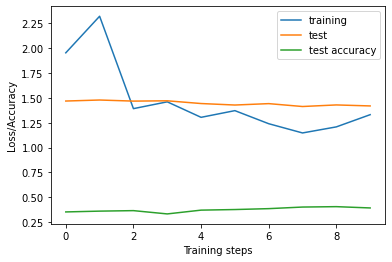

In [ ]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()